<h1>Brain Tumor Detection Demo</h1>

Install neccesary libraries

In [1]:
!pip install seaborn
!pip install pyyaml h5py

Import neccesary libraries

In [4]:
import os
from tensorflow import keras
import numpy as np
import pandas as pd
from tensorflow import keras
import seaborn as sns
import matplotlib.pyplot as plt
from keras import Sequential
import tensorflow as tf
from IPython import display
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras import Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

<h2>Dataset Distribution</h2>

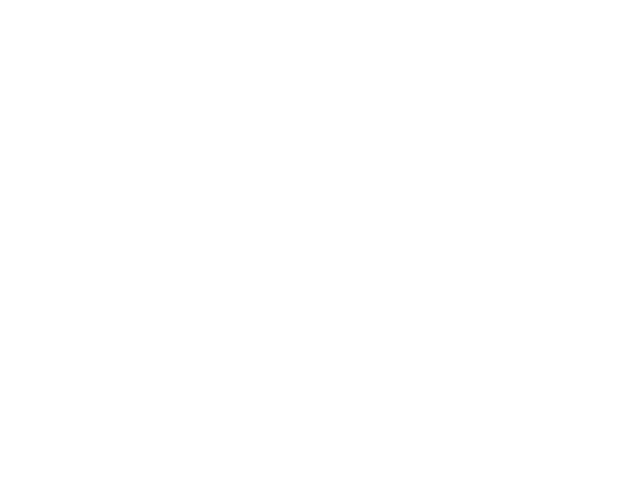

In [6]:
display.Image("/home/sagemaker-user/BrainTumorDetectionML/plots/dataDistribution.png")